In [1]:
import geopandas as gpd

In [2]:
import zipfile 
import os
zip_path = 'mrds-trim.zip' 
extract_to = 'data'
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref: zip_ref.extractall(extract_to)

In [3]:
#find the names of the files I just unzipped
for root, dirs, files in os.walk(extract_to):
    for file in files:
        print(os.path.join(root, file))

data/mrds-trim.shp
data/mrds-trim.shx
data/mrds.met
data/mrds-trim.dbf
data/mrds-trim.prj
data/mrds-trim.lyr


In [4]:
minerals = gpd.read_file("data/mrds-trim.shp")

In [5]:
print(minerals.shape)

(304632, 6)


In [6]:
print(minerals.columns)

Index(['DEP_ID', 'SITE_NAME', 'DEV_STAT', 'URL', 'CODE_LIST', 'geometry'], dtype='object')


In [7]:
print(minerals.head())

     DEP_ID            SITE_NAME    DEV_STAT  \
0  10000001     Lookout Prospect  Occurrence   
1  10000002  Lucky Find Prospect  Occurrence   
2  10000003  Mccullough Prospect  Occurrence   
3  10000004      Lucky Jim Claim  Occurrence   
4  10000005   Matilda Occurrence  Occurrence   

                                                 URL CODE_LIST  \
0  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU AU AG   
1  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     CU AU   
2  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU ZN AU   
3  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU PB CU   
4  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        AU   

                      geometry  
0  POINT (-132.14344 55.05612)  
1  POINT (-132.68514 55.52751)  
2  POINT (-132.99906 55.97751)  
3  POINT (-132.68653 55.52195)  
4  POINT (-132.05233 55.14556)  


In [8]:
#we want to find the mines that do contain lithium as a preliminary investigation of what other minerals are there
filtered_minerals = minerals[minerals['CODE_LIST'].str.contains('LI', na=False)]

In [9]:
print(filtered_minerals.shape)

(566, 6)


In [10]:
print(filtered_minerals.head())

        DEP_ID                SITE_NAME       DEV_STAT  \
4108  10004123             La Teresaida     Occurrence   
4156  10004198                   Ipizca     Occurrence   
4157  10004199  Salar Del Hombre Muerto     Occurrence   
4159  10004201         Reflejos Del Mar     Occurrence   
4165  10004207              Victor Hugo  Past Producer   

                                                    URL  \
4108  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4156  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4157  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4159  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   
4165  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   

                   CODE_LIST                     geometry  
4108       LI QTZ FLD MIC NB  POINT (-65.83271 -32.66411)  
4156                   LI BE  POINT (-65.54107 -28.72578)  
4157            LI K B CS RB  POINT (-66.99944 -25.24749)  
4159                   LI BE   POINT (-65.4494 -28.44745

In [11]:
#now we want to look at the mines that do not contain lithium 
no_lithium_minerals = minerals[~minerals['CODE_LIST'].str.contains('LI', na=False)]

In [12]:
print(no_lithium_minerals.shape)

(304066, 6)


In [13]:
print(no_lithium_minerals.head())

     DEP_ID            SITE_NAME    DEV_STAT  \
0  10000001     Lookout Prospect  Occurrence   
1  10000002  Lucky Find Prospect  Occurrence   
2  10000003  Mccullough Prospect  Occurrence   
3  10000004      Lucky Jim Claim  Occurrence   
4  10000005   Matilda Occurrence  Occurrence   

                                                 URL CODE_LIST  \
0  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU AU AG   
1  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     CU AU   
2  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  CU ZN AU   
3  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  AU PB CU   
4  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...        AU   

                      geometry  
0  POINT (-132.14344 55.05612)  
1  POINT (-132.68514 55.52751)  
2  POINT (-132.99906 55.97751)  
3  POINT (-132.68653 55.52195)  
4  POINT (-132.05233 55.14556)  


In [14]:
#we want to restrict to only north carolina as part of our first exploratory analysis
#we know from the North Carolina wikipedia page the longitude and latitude of the state bounds: https://en.wikipedia.org/wiki/North_Carolina

In [15]:

min_lat, max_lat = 33.8333, 36.5833
min_lon, max_lon = -84.3167, -75.4667


minerals['longitude'] = minerals.geometry.x
minerals['latitude'] = minerals.geometry.y


minerals_nc = minerals[
    (minerals['latitude'] >= min_lat) & (minerals['latitude'] <= max_lat) &
    (minerals['longitude'] >= min_lon) & (minerals['longitude'] <= max_lon)
]

import geopandas as gpd

# --- Load NC boundary polygon ---
nc_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(nc_url)
nc = us_states[us_states['NAME'] == "North Carolina"]

# --- Ensure both layers are in the same CRS ---
# MRDS shapefile probably has a geographic CRS (EPSG:4326)
minerals = minerals.to_crs(nc.crs)

# --- Keep only points within the NC boundary ---
minerals_nc = minerals[minerals.within(nc.geometry.iloc[0])]

print(f"Original count: {len(minerals)}")
print(f"Points strictly INSIDE NC: {len(minerals_nc)}")
print(minerals_nc.head())

Original count: 304632
Points strictly INSIDE NC: 5184
         DEP_ID             SITE_NAME    DEV_STAT  \
8293   10008424             Boy Scout  Occurrence   
8294   10008425  Robert Miller's Farm  Occurrence   
8913   10009176         Randolph Mine    Producer   
8914   10009177            Deake Mine    Producer   
23804  10024735         Bessemer City    Prospect   

                                                     URL      CODE_LIST  \
8293   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...       MO CU AG   
8294   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...             MO   
8913   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  NB TA MIC FLD   
8914   https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  NB TA MIC FLD   
23804  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  LI FLD MIC BE   

                         geometry  longitude  latitude  
8293   POINT (-77.87999 36.25841)  -77.87999  36.25841  
8294   POINT (-82.26652 36.05009)  -82.26652  36.05009  
8913

In [16]:
#before we do calculate any distances with our data we should first convert to a north carolina specific epsg for greater spatial accuracy
minerals_nc_projected = minerals_nc.to_crs(epsg=32119)

#get rid of processing sites since minerals not explicitly mined there
#get rid of sites that just have SDG as their only output since that's sand and gravel rather than a mineral
minerals_nc_projected = minerals_nc_projected[
    ~minerals_nc_projected['DEV_STAT'].isin(['Unknown', 'Plant']) &
    ~(minerals_nc_projected['CODE_LIST'] == 'SDG')
]

In [17]:
#now within north carolina we want to pick one mine that contains lithium and then see distances to the other mines that do not have lithium
#first we find one mine that contains lithium
li_mines = minerals_nc_projected[minerals_nc_projected['CODE_LIST'].str.contains('LI', na=False)]
print(li_mines.iloc[0])

DEP_ID                                                10024735
SITE_NAME                                        Bessemer City
DEV_STAT                                              Prospect
URL          https://mrdata.usgs.gov/mrds/show-mrds.php?dep...
CODE_LIST                                        LI FLD MIC BE
geometry          POINT (411158.35356054205 177832.1177242969)
longitude                                            -81.18315
latitude                                              35.33343
Name: 23804, dtype: object


In [18]:
#filtering for just mines that do not contain lithium
non_li_mines = minerals_nc_projected[~minerals_nc_projected['CODE_LIST'].str.contains('LI', na=False)]

In [19]:
non_li_mines.shape

(4097, 8)

In [20]:
bessemer_city_geom = minerals_nc_projected.loc[23804, 'geometry']

In [21]:
print(bessemer_city_geom)

POINT (411158.35356054205 177832.1177242969)


In [22]:
non_li_mines = non_li_mines.copy()
non_li_mines['distance_to_bessemer'] = non_li_mines.geometry.distance(bessemer_city_geom)

In [23]:
#find the closest 5 non-lithium containing mines to those mines: 
print(non_li_mines[['DEP_ID', 'SITE_NAME', 'distance_to_bessemer', "CODE_LIST", "DEV_STAT"    ]].sort_values('distance_to_bessemer').head())

          DEP_ID                            SITE_NAME  distance_to_bessemer  \
77168   10079365          Unnamed Stone Quarry Fk-045           5656.158917   
289697  10297157                          Froneberger           6736.910632   
76774   10078901    Spencer Mountain Quartzite Quarry           7203.219208   
77009   10079138                    Unnamed Gold Mine           7338.141278   
76772   10078899  Spencer Mountain Kyanite Occurrence           7403.866932   

       CODE_LIST       DEV_STAT  
77168        STN       Producer  
289697        MN       Prospect  
76774        STN  Past Producer  
77009         AU  Past Producer  
76772    QTZ KYN     Occurrence  


In [24]:
#now find the closest 20:
print(
    non_li_mines[
        ['DEP_ID', 'SITE_NAME', 'distance_to_bessemer', 'CODE_LIST', 'DEV_STAT']
    ].sort_values('distance_to_bessemer').head(20)
)

          DEP_ID                            SITE_NAME  distance_to_bessemer  \
77168   10079365          Unnamed Stone Quarry Fk-045           5656.158917   
289697  10297157                          Froneberger           6736.910632   
76774   10078901    Spencer Mountain Quartzite Quarry           7203.219208   
77009   10079138                    Unnamed Gold Mine           7338.141278   
76772   10078899  Spencer Mountain Kyanite Occurrence           7403.866932   
274491  10281543                      Long Creek Mine           7592.428267   
87224   10089674                    Unnamed Gold Mine           7596.672058   
97512   10100209                    Unnamed Gold Mine           7651.684534   
123712  10127217                          Oliver Mine           7877.570943   
171070  10175745                         Costner Mine           7987.178188   
194561  10199779    Walter and Gerard Pesaur Property           8010.488301   
170742  10175417                         Ellison Min

In [25]:
#These are close mines which means that lithium mines are near mines that do not contain lithium, so we can proceed!

# KMEANS on North Carolina Mines

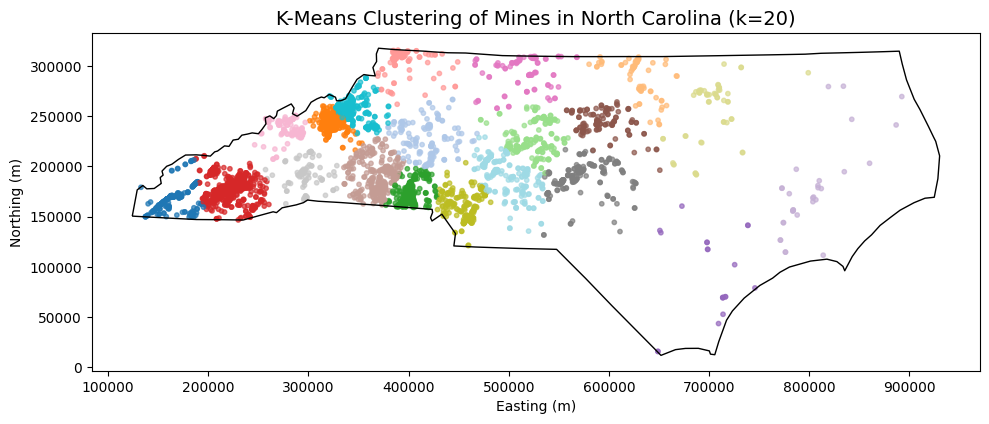

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- STEP 1: Prepare GeoDataFrame ---
gdf = minerals_nc_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# --- STEP 2: Run K-Means clustering ---
k = 20  # Number of clusters (change as needed)
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)

# --- STEP 3: Load a strict North Carolina boundary ---
nc_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(nc_url)
nc = us_states[us_states['NAME'] == "North Carolina"].to_crs(gdf.crs)

# --- STEP 4: Plot NC basemap + clusters (no legend) ---
fig, ax = plt.subplots(figsize=(10, 8))

nc.boundary.plot(ax=ax, color='black', linewidth=1)

# mines colored by clusters, no legend
gdf.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7, legend=False)

ax.set_title(f"K-Means Clustering of Mines in North Carolina (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

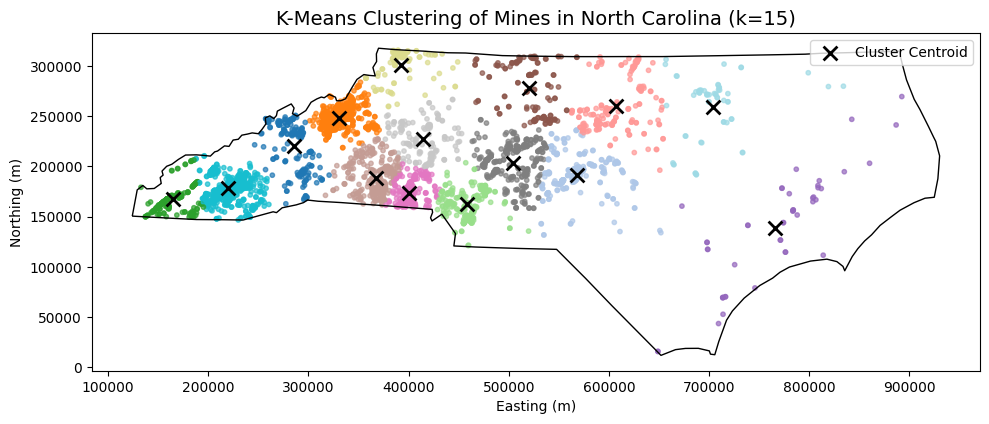

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- STEP 1: Prepare GeoDataFrame ---
gdf = minerals_nc_projected.copy()
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# --- STEP 2: Run K-Means clustering ---
k = 15  # number of clusters
coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
gdf['cluster'] = kmeans.fit_predict(coords)

# --- STEP 3: Load strict North Carolina boundary ---
nc_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"
us_states = gpd.read_file(nc_url)
nc = us_states[us_states['NAME'] == "North Carolina"].to_crs(gdf.crs)

# --- STEP 4: Plot NC basemap + clusters + centroids ---
fig, ax = plt.subplots(figsize=(10, 8))

# Plot NC outline
nc.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot mines by cluster (no legend)
gdf.plot(ax=ax, column='cluster', cmap='tab20',
         markersize=10, alpha=0.7, legend=False)

# Add cluster centroids (in projected coordinates, same CRS)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            marker='x', s=100, c='black', linewidths=2,
            label='Cluster Centroid')

# Optional: add a legend just for the centroids (not clusters)
plt.legend()

ax.set_title(f"K-Means Clustering of Mines in North Carolina (k={k})", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [28]:
# --- Add cluster assignments back into the original dataset ---
minerals_nc_projected['cluster'] = gdf['cluster'].values

# --- (Optional) show a few columns to verify ---
print(minerals_nc_projected[['DEP_ID', 'SITE_NAME', 'cluster', 'CODE_LIST']].head())

         DEP_ID             SITE_NAME  cluster      CODE_LIST
8293   10008424             Boy Scout       14       MO CU AG
8294   10008425  Robert Miller's Farm        2             MO
8913   10009176         Randolph Mine        2  NB TA MIC FLD
8914   10009177            Deake Mine        2  NB TA MIC FLD
23804  10024735         Bessemer City        9  LI FLD MIC BE


In [29]:
import pandas as pd

# --- STEP 1: Make a copy of relevant columns ---
df = minerals_nc_projected[['cluster', 'CODE_LIST', 'geometry']].copy()

# Drop rows where CODE_LIST is missing or empty
df = df.dropna(subset=['CODE_LIST'])
df = df[df['CODE_LIST'].str.strip() != '']

# --- STEP 2: Split CODE_LIST into separate elements ---
# e.g. "NB TA MIC FLD" -> ["NB", "TA", "MIC", "FLD"]
df['elements'] = df['CODE_LIST'].str.split(r'\s+')

# --- STEP 3: Explode the list so each element becomes its own row ---
df_exploded = df.explode('elements')

# Clean up whitespace or empty strings
df_exploded['elements'] = df_exploded['elements'].str.strip()
df_exploded = df_exploded[df_exploded['elements'] != '']

# --- STEP 4: Count frequency of each element per cluster ---
element_freq = (
    df_exploded
    .groupby(['cluster', 'elements'])
    .size()
    .reset_index(name='count')
    .sort_values(['cluster', 'count'], ascending=[True, False])
)

print(element_freq.head(30))  # show top 30 rows

# --- (Optional) Pivot into a wide table for easier reading ---
freq_table = (
    element_freq
    .pivot(index='elements', columns='cluster', values='count')
    .fillna(0)
    .astype(int)
)

print(freq_table.head(20))  # first few elements across clusters

top5_elements_per_cluster = (
    element_freq
    .groupby('cluster')
    .head(5)
    .reset_index(drop=True)
)

print(top5_elements_per_cluster)

top_elements_summary = (
    top5_elements_per_cluster
    .groupby('elements')['count']
    .sum()
    .reset_index()
    .sort_values('count', ascending=False)
)

print(top_elements_summary)

    cluster elements  count
41        0      TLC     47
18        0      FLD     25
43        0        W     23
16        0       FE     22
36        0    STN_C     21
40        0     TI_M     14
23        0      MIC     13
13        0       CR     12
24        0       MN     12
15        0        F     11
6         0       BA     10
45        0       ZR      9
8         0      CLY      8
14        0       CU      8
21        0      MBL      8
29        0       PB      8
27        0      OLV      7
19        0      GRT      5
26        0       NI      5
33        0      REE      5
34        0        S      5
39        0       TH      5
42        0      VRM      4
1         0       AG      3
4         0      ASB      3
5         0       AU      3
25        0       MO      3
37        0    STN_D      3
2         0       AL      2
9         0   CLY_BK      2
cluster   0   1   2   3    4   5   6   7   8   9    10  11  12  13  14
elements                                                     

# Distance metrics and density measurements

Based on geochemical research articles cited in our analysis paper, the minerals which serve as the best indicators of lithium presence are: tin, quartz, mica, feldspar, beryllium, and cesium. Using that, we want to calculate the density of each of these minerals within a certain radius of the centroid of each cluster. We will use a radius of 10 miles away from the centroid. Then we count the number of that specific mineral in that radius and the total number of minerals in that radius and take the proportion as the density of that mineral. That will serve as a predictor for the presence of lithium in our model. Recall that we are predicting the overall probability that lithium is present in the cluster using these densities as variables.

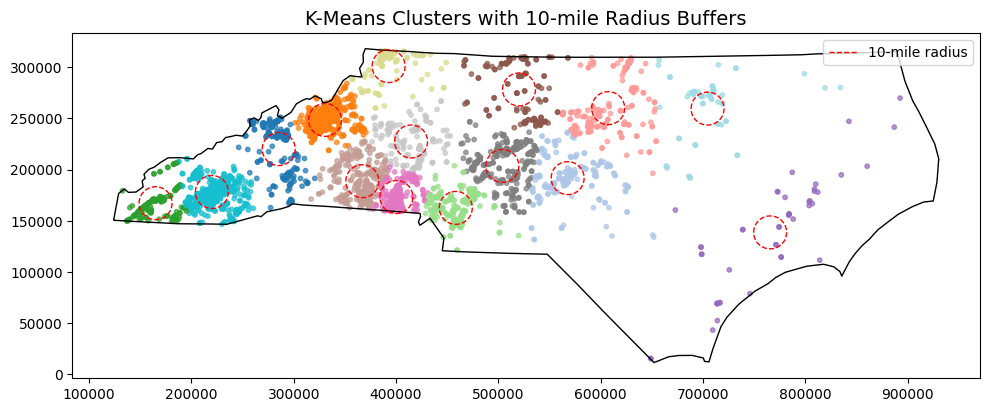

In [30]:
#Since we want 10 mile radius, we need to see what that is in meters first.
radius_meters = 10 * 1609.34


#then we determine the 10 mile radius from the centroid
from shapely.geometry import Point
centroid_points = [Point(xy) for xy in centers]  # centers = kmeans.cluster_centers_
centroids_gdf = gpd.GeoDataFrame({'cluster': range(len(centers))},
                                 geometry=centroid_points,
                                 crs=minerals_nc_projected.crs)


buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)


fig, ax = plt.subplots(figsize=(10, 8))

nc.boundary.plot(ax=ax, color='black', linewidth=1)
buffers_gdf.boundary.plot(ax=ax, color='red', linestyle='--', linewidth=1, label='10-mile radius')
minerals_nc_projected.plot(ax=ax, column='cluster', cmap='tab20', markersize=10, alpha=0.7)

plt.legend()
ax.set_title("K-Means Clusters with 10-mile Radius Buffers", fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
#now we count the prevalence of our elements of interest within those 5 mile radii
# --- STEP 1: Prepare exploded dataframe with geometry ---
df = minerals_nc_projected[['cluster', 'CODE_LIST', 'geometry']].copy()
df = df.dropna(subset=['CODE_LIST'])
df = df[df['CODE_LIST'].str.strip() != '']
df['elements'] = df['CODE_LIST'].str.split(r'\s+')

df_exploded = df.explode('elements')
df_exploded['elements'] = df_exploded['elements'].str.strip()
df_exploded = df_exploded[df_exploded['elements'] != '']
df_exploded = gpd.GeoDataFrame(df_exploded, geometry='geometry', crs=minerals_nc_projected.crs)

# --- STEP 2: Build centroid buffers (10 miles ≈ 16093 m) ---
radius_meters = 10 * 1609.34
centroid_points = [Point(xy) for xy in centers]  # centers = kmeans.cluster_centers_
centroids_gdf = gpd.GeoDataFrame({'cluster': range(len(centers))},
                                 geometry=centroid_points,
                                 crs=minerals_nc_projected.crs)
buffers_gdf = centroids_gdf.copy()
buffers_gdf['geometry'] = buffers_gdf.buffer(radius_meters)

# --- STEP 3: Spatial join mines to buffers ---
joined = gpd.sjoin(df_exploded, buffers_gdf, how='inner', predicate='within')
# --- STEP 4: Filter for target elements ---
target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']
filtered = joined[joined['elements'].isin(target_elements)]

# --- STEP 5: Group and count by buffer cluster (cluster_right) ---
counts = (filtered.groupby(['cluster_right', 'elements'])
                    .size()
                    .reset_index(name='count'))

print(counts)

    cluster_right elements  count
0               0      FLD     13
1               0      MIC      4
2               1      MIC      5
3               2       BE      1
4               2      FLD    513
5               2      MIC    794
6               2      QTZ     11
7               4      QTZ      1
8               8       BE      3
9               8      FLD      1
10              8      MIC     99
11              8      QTZ      1
12              9       BE      9
13              9       CS      1
14              9      FLD     63
15              9      MIC     58
16              9      QTZ     54
17              9       SN    103
18             11       BE      2
19             11      FLD      1
20             11      MIC     16
21             13      MIC    207


In [32]:
#now we want to find the proportion of minerals in each cluster that are these minerals so we need the total number 
#of elements in that 10 mile radius and then we take the proportions
totals = (
    joined.groupby('cluster_right')
          .size()
          .reset_index(name='total_number_of_minerals')
)

# --- Step 7: Merge totals with counts of target elements ---
counts_with_totals = counts.merge(totals, on='cluster_right')

# --- Step 8: Calculate proportion ---
counts_with_totals['proportion'] = counts_with_totals['count'] / counts_with_totals['total_number_of_minerals']

print(counts_with_totals)

    cluster_right elements  count  total_number_of_minerals  proportion
0               0      FLD     13                        77    0.168831
1               0      MIC      4                        77    0.051948
2               1      MIC      5                        98    0.051020
3               2       BE      1                      1474    0.000678
4               2      FLD    513                      1474    0.348033
5               2      MIC    794                      1474    0.538670
6               2      QTZ     11                      1474    0.007463
7               4      QTZ      1                       141    0.007092
8               8       BE      3                       128    0.023438
9               8      FLD      1                       128    0.007812
10              8      MIC     99                       128    0.773438
11              8      QTZ      1                       128    0.007812
12              9       BE      9                       534    0

In [45]:
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# --- STEP 1: Define all clusters ---
all_clusters_idx = pd.Index(buffers_gdf['cluster'], name='cluster_right')

# --- STEP 2: Element proportions (within 10-mile buffers) ---
target_elements = ['QTZ', 'MIC', 'FLD', 'BE', 'CS', 'SN']

element_counts = (
    joined[joined['elements'].isin(target_elements)]
    .groupby(['cluster_right', 'elements'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='elements', values='count')
)
element_counts_full = element_counts.reindex(all_clusters_idx).fillna(0)

totals_full = (
    joined.groupby('cluster_right')
    .size()
    .reindex(all_clusters_idx)
    .fillna(0)
    .rename('total')
)

# Safe division: if mineral not present, proportion = 0
element_props = element_counts_full.div(totals_full, axis=0).fillna(0)

# --- STEP 3: DEV_STAT counts (within 10-mile buffers) ---
dev_counts = (
    minerals_nc_projected
    .sjoin(buffers_gdf, how='inner', predicate='within')
    .groupby(['cluster_right', 'DEV_STAT'])
    .size()
    .reset_index(name='count')
    .pivot(index='cluster_right', columns='DEV_STAT', values='count')
)
dev_counts_full = dev_counts.reindex(all_clusters_idx).fillna(0)

# Add num_places = total DEV_STAT entries per cluster (within buffer)
dev_counts_full['num_places'] = dev_counts_full.sum(axis=1)

# --- STEP 4: Predictors (X) ---
X = element_props.merge(dev_counts_full, left_index=True, right_index=True)

# Drop unwanted predictors
drop_cols = ['Past Producer', 'Producer', 'Occurrence', 'Prospect']
X = X.drop(columns=[c for c in drop_cols if c in X.columns])

# --- STEP 5: Target (y) ---
y = (
    cluster_targets.set_index('cluster_right')
    .reindex(all_clusters_idx)['LI_present']
    .fillna(0)
    .astype(int)
)

# --- STEP 6: Logistic regression pipeline ---
logreg = LogisticRegression(
    max_iter=1000,
    random_state=0,
    class_weight='balanced'
)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', logreg)
])

# --- STEP 7: Fit model ---
pipe.fit(X, y)

# --- STEP 8: Inspect coefficients ---
coef = pd.Series(pipe.named_steps['logreg'].coef_[0], index=X.columns)
print("Logistic regression coefficients (sorted):")
print(coef.sort_values(ascending=False))
print("\nIntercept:", pipe.named_steps['logreg'].intercept_[0])

# --- STEP 9: Predictions and evaluation ---
y_pred = pipe.predict(X)
y_prob = pipe.predict_proba(X)[:, 1]

results = pd.DataFrame({
    'LI_present': y,
    'predicted_class': y_pred,
    'predicted_prob': y_prob
}, index=X.index)

print("\nClassification report:")
print(classification_report(y, y_pred, digits=3))
print("\nCluster-level predictions:")
print(results)


Logistic regression coefficients (sorted):
CS            0.626651
SN            0.626651
QTZ           0.619426
BE            0.119516
FLD           0.100791
num_places    0.054059
MIC          -0.057033
dtype: float64

Intercept: -3.3526513804667504

Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        14
           1      1.000     1.000     1.000         1

    accuracy                          1.000        15
   macro avg      1.000     1.000     1.000        15
weighted avg      1.000     1.000     1.000        15


Cluster-level predictions:
               LI_present  predicted_class  predicted_prob
cluster_right                                             
0                       0                0        0.021631
1                       0                0        0.018327
2                       0                0        0.034594
3                       0                0        0.018673
4               

In [59]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Original class distribution:", y.value_counts().to_dict())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts().to_dict())



Original class distribution: {0: 14, 1: 1}
Resampled class distribution: {0: 14, 1: 14}
